Usage the images. Might be too hard since the ball is very difficult to see.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

## Data

In [3]:
image_train = np.load('data/processed/image_train.npy').astype(np.float32) / 255
change_train = np.load('data/processed/change_train.npy').astype(np.float32) / 255
label_train = np.load('data/processed/label_train.npy').astype(np.float32)

image_test = np.load('data/processed/image_test.npy').astype(np.float32) / 255
change_test = np.load('data/processed/change_test.npy').astype(np.float32) / 255
label_test = np.load('data/processed/label_test.npy').astype(np.float32)

In [4]:
print(image_train.shape, change_train.shape, label_train.shape)
print(image_test.shape, change_test.shape, label_test.shape)

(520, 3, 280, 600) (520, 1, 280, 600) (520, 2)
(80, 3, 280, 600) (80, 1, 280, 600) (80, 2)


In [5]:
class TrebuchetDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(TrebuchetDataset, self).__init__()
        self.X = X # Should have shape (ysize, xsize, channels, frames)
        self.y = y # Should have shape (frames,)
        assert len(X) == len(y)
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        return (self.X[idx, ...], self.y[idx, ...])

In [14]:
train_dataset = TrebuchetDataset(image_train, label_train)
test_dataset = TrebuchetDataset(image_test, label_test)

In [15]:
# Must have batch size 20
train_dataloader = DataLoader(train_dataset, batch_size=20)
test_dataloader = DataLoader(test_dataset, batch_size=20)

In [16]:
# Check I/O size
features, label = next(iter(train_dataloader))
features.shape, label.shape

(torch.Size([20, 3, 280, 600]), torch.Size([20, 2]))

## Model

In [38]:
class Net(nn.Module):
    """
    3 x (Conv2d-> MaxPool2d), then flattened and passed to 3 x Linear
    """
    def __init__(self):
        super(Net, self).__init__()
        layers = [
            # Input X expected to have shape (20, 3, 280, 600)
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), stride=(1, 1)),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=(1, 1)),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1)),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1)),
            nn.MaxPool2d(kernel_size=(2, 2)), 
            # At this point, X shape is (20, 64, 15, 35)
            
            # nn.Conv2d(in_channels=64, out_channels=1, kernel_size=(1, 1), stride=(1, 1)), # add this one? should trim num weights further
            
            # Flattened shape is (20, 1*15*35) = (20, 525)
            nn.Flatten(),
            nn.Linear(in_features=64*15*35, out_features=64),
            nn.SELU(),
            nn.Linear(in_features=64, out_features=8),
            nn.SELU(),
            nn.Linear(in_features=8, out_features=2),
            nn.Sigmoid() # Hard cap to 0 - 1 range
        ]

        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [39]:
net = Net()
net.train();

In [40]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

In [41]:
# Verify net I/O size
test_output = net(torch.randn(20, 3, 280, 600))

In [42]:
test_output.shape

torch.Size([20, 2])

In [43]:
epochs = 60

In [44]:
for epoch in range(epochs):
    running_loss = 0
    
    for count, (features, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = net(features)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'{epoch+1} loss: {running_loss/count:.3g}')

1 loss: 0.0355
2 loss: 0.0296
3 loss: 0.0281
4 loss: 0.028
5 loss: 0.0278
6 loss: 0.0277
7 loss: 0.0278
8 loss: 0.0278
9 loss: 0.0276
10 loss: 0.0276
11 loss: 0.0275
12 loss: 0.0265
13 loss: 0.0334
14 loss: 0.0275
15 loss: 0.0259
16 loss: 0.0239
17 loss: 0.0186
18 loss: 0.0114
19 loss: 0.00705
20 loss: 0.00551
21 loss: 0.00407
22 loss: 0.00333
23 loss: 0.00273
24 loss: 0.00225
25 loss: 0.0019
26 loss: 0.00153
27 loss: 0.00136
28 loss: 0.00136
29 loss: 0.0016
30 loss: 0.00108
31 loss: 0.0012
32 loss: 0.00132
33 loss: 0.000905
34 loss: 0.000977
35 loss: 0.000858
36 loss: 0.000671
37 loss: 0.000611
38 loss: 0.000552
39 loss: 0.000496
40 loss: 0.000477
41 loss: 0.000476
42 loss: 0.000473
43 loss: 0.000489
44 loss: 0.000503
45 loss: 0.000456
46 loss: 0.000419
47 loss: 0.000593
48 loss: 0.000507
49 loss: 0.000554
50 loss: 0.0004
51 loss: 0.00042
52 loss: 0.000453
53 loss: 0.000412
54 loss: 0.000415
55 loss: 0.000379
56 loss: 0.000293
57 loss: 0.000347
58 loss: 0.000338
59 loss: 0.000287
60 l

In [45]:
image_train_ten = torch.FloatTensor(image_train)
image_test_ten = torch.FloatTensor(image_test)

In [46]:
net.eval();

In [47]:
label_train_hat_list = []
label_test_hat_list = []

with torch.no_grad():
    for features, label in train_dataloader:
        label_train_hat = net(features)
        label_train_hat_list.append(label_train_hat)

    for features, label in test_dataloader:
        label_test_hat = net(features)
        label_test_hat_list.append(label_test_hat)

In [48]:
label_train_hat = torch.cat(label_train_hat_list, dim=0)
label_test_hat = torch.cat(label_test_hat_list, dim=0)

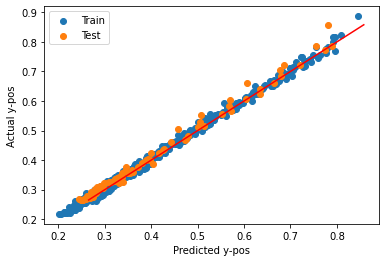

In [49]:
plt.ylabel('Actual y-pos')
plt.xlabel('Predicted y-pos')
plt.scatter(label_train_hat[:, 1], label_train[:, 1], label='Train', c='C0')
plt.scatter(label_test_hat[:, 1], label_test[:, 1], label='Test', c='C1')

# Plot y=x red line
plt.plot(
    [label_test[:, 1].min(), label_test[:, 1].max()], 
    [label_test[:, 1].min(), label_test[:, 1].max()], 
    c='red'
)
plt.legend()
plt.show()

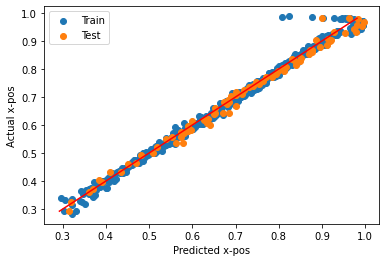

In [50]:
plt.ylabel('Actual x-pos')
plt.xlabel('Predicted x-pos')
plt.scatter(label_train_hat[:, 0], label_train[:, 0], label='Train', c='C0')
plt.scatter(label_test_hat[:, 0], label_test[:, 0], label='Test', c='C1')

# Plot y=x red line
plt.plot(
    [label_test[:, 0].min(), label_test[:, 0].max()], 
    [label_test[:, 0].min(), label_test[:, 0].max()], 
    c='red'
)
plt.legend()
plt.show()

In [52]:
torch.save(net, "output/sl-baseline-rgb.pt")